<a href="https://colab.research.google.com/github/enzocatorano/deep_learning_practicas/blob/master/8_1_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Profundo FICH: Transformers y Mecanismos de atención
## Fine-tuning de un modelo pre-entrenado BERT

En esta notebook vamos a aprender a realizar un ajuste fino en un modelo pre-entrenado de tipo BERT. El objetivo es que puedan ver como tokenizar automaticament un texto y enmascararlo correctamente. Una vez concluido este paso, poder realizar un ajuste funo usando la función Trainer a partir de la librería de [Hugging Face](https://huggingface.co/transformers/).

Para más colab con distintas aplicaciones de Transformers a problemas de NLP recomendamos [acá](https://huggingface.co/transformers/notebooks.html).

In [1]:
!pip install transformers
from transformers import BertTokenizer, BertForMaskedLM, TrainingArguments, Trainer
import torch

# Cargamos modelos pre-entrenados



In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Tokenización


De la tokenización recibimos tres tensores:



1.   input_ids
2.   token_type_ids
3.   attention_mask

Aqui el mas importante es *input_ids* el cual nos devuelve la tokenización. Los otros dos tensores sirven para otras aplicaciones. Pueden ver mas info en [Hugging Face](https://huggingface.co/transformers/glossary.html)








In [3]:
text = ("After Abraham Lincoln won the November 1860 presidential "
        "election on an anti-slavery platform, an initial seven "
        "slave states declared their secession from the country "
        "to form the Confederacy. War broke out in April 1861 "
        "when secessionist forces attacked Fort Sumter in South "
        "Carolina, just over a month after Lincoln's "
        "inauguration.")

inputs = tokenizer(text, return_tensors='pt')
inputs.keys()


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

# Creamos etiquetas

Utilizamos el input_ids para crear las mismas etiquetas. Dado que no necesitamos gradiente en las mismas lo eliminamos con detach.

In [4]:
inputs['labels'] = inputs.input_ids.detach().clone()
inputs

{'input_ids': tensor([[  101,  2044,  8181,  5367,  2180,  1996,  2281,  7313,  4883,  2602,
          2006,  2019,  3424,  1011,  8864,  4132,  1010,  2019,  3988,  2698,
          6658,  2163,  4161,  2037, 22965,  2013,  1996,  2406,  2000,  2433,
          1996, 18179,  1012,  2162,  3631,  2041,  1999,  2258,  6863,  2043,
         22965,  2923,  2749,  4457,  3481,  7680,  3334,  1999,  2148,  3792,
          1010,  2074,  2058,  1037,  3204,  2044,  5367,  1005,  1055, 17331,
          1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'labels': tensor([

# Enmascaramiento

Aca usamos la estrategia de BERT, donde enmascaramos el 15% de los token de entrada de cada sentencia.

In [5]:
# Creamos un array aleatorio con el largo del vector
rand = torch.rand(inputs.input_ids.shape)
# Para aquellos valores menores a 0.15, los seteamos como True.
mask_arr = rand < 0.15
mask_arr

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False,  True, False,  True, False, False, False, False, False,
          True, False, False, False,  True, False, False,  True, False, False,
         False, False,  True, False, False, False,  True,  True,  True, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False,  True, False, False, False, False, False, False, False,
         False, False]])

Ahora usamos *mask_arr* para seleccionar aquellos lugares de la oración que le pondremos el token 103 correspondiente a la MASK.
Hay que tener cuidado de no reemplazar por accidente aquellas posiciones que corresponden a otro token importantes como CLS o SEP (101 y 102 respectivamente)

Por tanto verificamos que esas posiciones donde dice True no sean 101 o 102.

In [6]:
(inputs.input_ids != 101) * (inputs.input_ids != 102)
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * (inputs.input_ids != 102)
mask_arr

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False,  True, False,  True, False, False, False, False, False,
          True, False, False, False,  True, False, False,  True, False, False,
         False, False,  True, False, False, False,  True,  True,  True, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False,  True, False, False, False, False, False, False, False,
         False, False]])

In [7]:
mask_arr.shape

torch.Size([1, 62])

Ahora que tenemos nuestro vector de máscaras, utilizamos esos indices para reemplazar esos tokens por el correspondiente a la máscara, es decir, por el 103.

In [8]:
# Creamos seleccion a partir de mask_arr
selection = torch.flatten((mask_arr[0]).nonzero()).tolist()
selection

[12, 14, 20, 24, 27, 32, 36, 37, 38, 52]

In [9]:
# Aplicamos los indices de la seleccion a inputs.input_ids, agregando el token de MASK (103)
inputs.input_ids[0, selection] = 103
inputs

{'input_ids': tensor([[  101,  2044,  8181,  5367,  2180,  1996,  2281,  7313,  4883,  2602,
          2006,  2019,   103,  1011,   103,  4132,  1010,  2019,  3988,  2698,
           103,  2163,  4161,  2037,   103,  2013,  1996,   103,  2000,  2433,
          1996, 18179,   103,  2162,  3631,  2041,   103,   103,   103,  2043,
         22965,  2923,  2749,  4457,  3481,  7680,  3334,  1999,  2148,  3792,
          1010,  2074,   103,  1037,  3204,  2044,  5367,  1005,  1055, 17331,
          1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'labels': tensor([

# Calculamos error del modelo sin fine-tuning

In [10]:
# Pasamos la entrada como parametro del modelo
outputs = model(**inputs)

# Obtenemos dos tensores de salida, loss and logits
print(outputs.keys())

outputs.loss

odict_keys(['loss', 'logits'])


tensor(1.0137, grad_fn=<NllLossBackward0>)

In [11]:
outputs.logits.shape, inputs.input_ids.shape

(torch.Size([1, 62, 30522]), torch.Size([1, 62]))

# Creamos dataset para fine-tuning

Ahora repetiremos todos los pasos anteriores para el tokenizado y la creación de las máscaras pero para un texto más largo. Luego realizaremos un ajuste fino del modelo con esas entradas.
Para ello utilizaremos el libro de LOTR.

También usaremos la función Trainer que trae la librería transformers para entrenar facilmente el modelo.

In [12]:
!gdown 1SbnXl4Cn3eKHiWQysi35P9cGST02CHJX

Downloading...
From: https://drive.google.com/uc?id=1SbnXl4Cn3eKHiWQysi35P9cGST02CHJX
To: /content/felowship_of_the_ring.txt
100% 1.00M/1.00M [00:00<00:00, 57.5MB/s]


In [13]:
with open('felowship_of_the_ring.txt', 'r') as fp:
    text_ft = fp.read().split('\n')
len(text_ft)

7744

In [14]:
inputs_ft = tokenizer(text_ft, return_tensors='pt', max_length=512, truncation=True, padding='max_length')

inputs_ft.input_ids.size()

torch.Size([7744, 512])

In [15]:
inputs_ft['labels'] = inputs_ft.input_ids.detach().clone()

inputs_ft.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [16]:
# create random array of floats with equal dimensions to input_ids tensor
rand = torch.rand(inputs_ft.input_ids.shape)
# create mask array
mask_arr = (rand < 0.15) * (inputs_ft.input_ids != 101) * \
           (inputs_ft.input_ids != 102) * (inputs_ft.input_ids != 0)
mask_arr

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [17]:
for i in range(inputs_ft.input_ids.shape[0]):
    selection = torch.flatten((mask_arr[i]).nonzero()).tolist() # esta linea la agregue yo
    inputs_ft.input_ids[i, selection] = 103

inputs_ft.input_ids

tensor([[  101, 23059,   102,  ...,     0,     0,     0],
        [  101,  2023,  6925,  ...,     0,     0,     0],
        [  101,   102,     0,  ...,     0,     0,     0],
        ...,
        [  101,   102,     0,  ...,     0,     0,     0],
        [  101,  2182,  4515,  ...,     0,     0,     0],
        [  101,   102,     0,  ...,     0,     0,     0]])

In [18]:
class LOTRDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

dataset_ft = LOTRDataset(inputs_ft)

# Realizamos fine-tuning para nuestra aplicación
Notar que si bien es un ajuste fino del modelo, seguimos entrenando el modelo de lenguaje por enmascaramiento (lo que en general se toma como pre-entrenamiento)

In [34]:
args = TrainingArguments(
    output_dir='out',
    per_device_train_batch_size=5,
    num_train_epochs=2,
    logging_steps= 100
)


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset_ft
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: enzocatorano (enzocatorano-universidad-nacional-del-litoral) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


<ipython-input-33-1078962487>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
100,1.531800
200,0.023600
300,0.024400
400,0.026200
500,0.022000
600,0.022400
700,0.025300
800,0.022400
900,0.022600
1000,0.020900


<ipython-input-33-1078962487>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-1078962487>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-1078962487>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-1078962487>:5: UserWarning: To copy construct from a tensor, 

TrainOutput(global_step=3098, training_loss=0.06547679614066462, metrics={'train_runtime': 1998.5776, 'train_samples_per_second': 7.75, 'train_steps_per_second': 1.55, 'total_flos': 4076516140646400.0, 'train_loss': 0.06547679614066462, 'epoch': 2.0})

In [2]:
# tengo que reinciar la sesion asi que voy a guardar el modelo fine-tuneado
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
# guardo
save_dir = '/content/drive/MyDrive/deep_learning'
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

('/content/drive/MyDrive/deep_learning/tokenizer_config.json',
 '/content/drive/MyDrive/deep_learning/special_tokens_map.json',
 '/content/drive/MyDrive/deep_learning/vocab.txt',
 '/content/drive/MyDrive/deep_learning/added_tokens.json')

In [41]:
# pruebo cargar antes de reiniciar, para checkear que todo ande bien
import os

save_dir = '/content/drive/MyDrive/deep_learning'
print("Archivos en", save_dir)
for fn in os.listdir(save_dir):
    print(" -", fn)

Archivos en /content/drive/MyDrive/deep_learning
 - 8_1_Transformers.ipynb
 - config.json
 - model.safetensors
 - tokenizer_config.json
 - special_tokens_map.json
 - vocab.txt


In [39]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

tokenizer_test = BertTokenizer.from_pretrained(save_dir)
model_test     = BertForMaskedLM.from_pretrained(save_dir)

text = "The quick brown fox jumps over the lazy dog."
inputs = tokenizer_test(text, return_tensors='pt')

with torch.no_grad():
    outputs = model_test(**inputs)

#    batch_size x seq_len x vocab_size
print("Logits shape:", outputs.logits.shape)

Logits shape: torch.Size([1, 12, 30522])


In [42]:
# check extra que propone chatgpt

import hashlib
import numpy as np

# 1) Extraé los pesos de embeddings
emb_weights = model.get_input_embeddings().weight.detach().cpu().numpy()

# 2) Calculá el checksum MD5
md5 = hashlib.md5(emb_weights.tobytes()).hexdigest()
print("Checksum embeddings (antes de reiniciar):", md5)

# Guárdalo en algún lado (por ejemplo, variable, nota, etc.)
saved_checksum = md5

Checksum embeddings (antes de reiniciar): 76b66cc2789fc11e22fc4b1eb66b169e


In [3]:
# ahora recargo el modelo
from transformers import BertTokenizer, BertForMaskedLM
model = BertForMaskedLM.from_pretrained('/content/drive/MyDrive/deep_learning')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/deep_learning')

In [5]:
# check
import hashlib
import numpy as np

# Nuevamente extraés los mismos pesos
emb_weights2 = model.get_input_embeddings().weight.detach().cpu().numpy()

# Volvés a calcular el MD5
md5_after = hashlib.md5(emb_weights2.tobytes()).hexdigest()
print("Checksum embeddings (después de reiniciar):", md5_after)

# Comprobás
if md5_after == "76b66cc2789fc11e22fc4b1eb66b169e":
    print("✅ ¡Coinciden! Tu modelo se guardó y recargó SIN ERRORES.")
else:
    print("❌ Algo falló: las huellas NO coinciden.")

Checksum embeddings (después de reiniciar): 76b66cc2789fc11e22fc4b1eb66b169e
✅ ¡Coinciden! Tu modelo se guardó y recargó SIN ERRORES.


***
***
## Ejercicio: finetuning para clasificación
Completar el workflow siguiente para entrenar y evaluar un clasificador de recomendaciones.

- Considerar diferentes estrategias de ajuste del learning rate y modelos preentrenados
- Como entrenar solo el clasificador final y no toda la red?

In [1]:
pip install -U datasets

In [54]:
from datasets import load_dataset

train_data = load_dataset("Yelp/yelp_review_full", split="train[:2000]")
train_data[100]

{'label': 0,
 'text': 'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. 

In [55]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_train_dataset = train_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [56]:
tokenized_train_dataset = tokenized_train_dataset.remove_columns(["text"])
tokenized_train_dataset = tokenized_train_dataset.rename_column("label", "labels")
tokenized_train_dataset.set_format("torch")

In [57]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(tokenized_train_dataset, shuffle=True, batch_size=1)
for batch in train_dataloader:
    break
batch.keys()

dict_keys(['labels', 'input_ids', 'token_type_ids', 'attention_mask'])

In [58]:
batch["labels"].shape, batch["input_ids"].shape

(torch.Size([1]), torch.Size([1, 512]))

In [98]:
# Definición del modelo
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [99]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [61]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params:      {total_params}")
print(f"Trainable params:  {trainable_params}")

Total params:      108314117
Trainable params:  108314117


In [62]:
# ambos numeros son iguales, por lo que hace falta congelar los parametros que no quieren ajustarse
for param in model.bert.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
classifier_params = sum(p.numel() for p in model.classifier.parameters())

print(f"Total params:      {total_params}")
print(f"Trainable params:  {trainable_params}")
print(f"Expected (classifier only): {classifier_params}")

Total params:      108314117
Trainable params:  3845
Expected (classifier only): 3845


In [101]:
# descongelo parcialmente a la bestia
for param in model.bert.parameters():
    param.requires_grad = False

for idx in [11]: # solo reactivo la ultima capa
    for param in model.bert.encoder.layer[idx].parameters():
        param.requires_grad = True

for param in model.bert.pooler.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
classifier_params = sum(p.numel() for p in model.classifier.parameters())

print(f"Total params:      {total_params}")
print(f"Trainable params:  {trainable_params}")
print(f"Expected (classifier only): {classifier_params}")

Total params:      108314117
Trainable params:  7682309
Expected (classifier only): 3845


In [102]:
# ahora si
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=1e-6) # baje aun mas el lr

In [103]:
from transformers import get_scheduler

num_epochs = 2 # baje las epocas para el reentrenamiento de la ultima capa de BERT
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=int(0.1*num_training_steps),
    num_training_steps=num_training_steps
)

In [104]:
import torch
from accelerate.test_utils.testing import get_backend

device, _, _ = get_backend()
model.to(device)
print(device)

cuda


In [105]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)


  0%|          | 0/4000 [00:00<?, ?it/s]

In [106]:
# evaluacion
from datasets import load_dataset
test_data = load_dataset("Yelp/yelp_review_full", split="test[:1000]")

tokenized_test = (
    test_data
    .map(tokenize_function, batched=True)
    .remove_columns(["text"])
    .rename_column("label", "labels")
    .with_format("torch")
)

from torch.utils.data import DataLoader
test_dataloader = DataLoader(tokenized_test, batch_size=16)

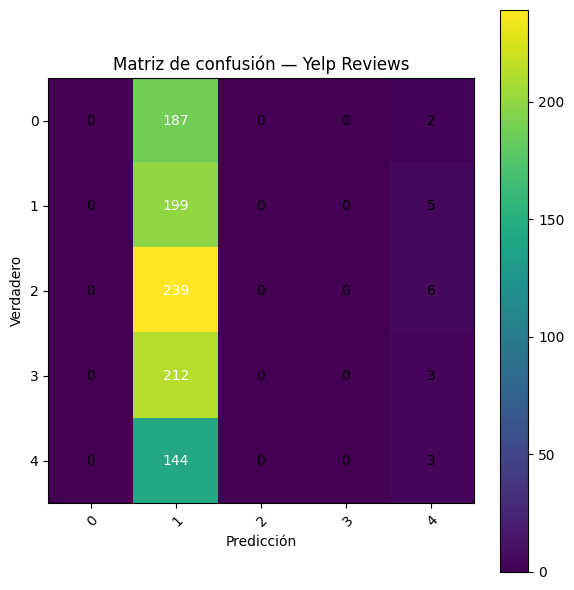

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       189
           1       0.20      0.98      0.34       204
           2       0.00      0.00      0.00       245
           3       0.00      0.00      0.00       215
           4       0.16      0.02      0.04       147

    accuracy                           0.20      1000
   macro avg       0.07      0.20      0.07      1000
weighted avg       0.06      0.20      0.07      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [107]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

true_labels = []
pred_labels = []

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = outputs.logits.argmax(dim=-1)
        true_labels.extend(batch["labels"].cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

true = np.array(true_labels)
pred = np.array(pred_labels)

# 2. Calculamos la matriz de confusión
cm = confusion_matrix(true, pred, labels=[0,1,2,3,4])

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)

# Etiquetas de ejes
classes = ['0','1','2','3','4']
ax.set(xticks=np.arange(len(classes)), yticks=np.arange(len(classes)),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicción', ylabel='Verdadero',
       title='Matriz de confusión — Yelp Reviews')

# Rotar etiquetas X
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Anotar cada celda
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

from sklearn.metrics import classification_report
print(classification_report(true, pred))


La matriz de confusion arrojaba esto:

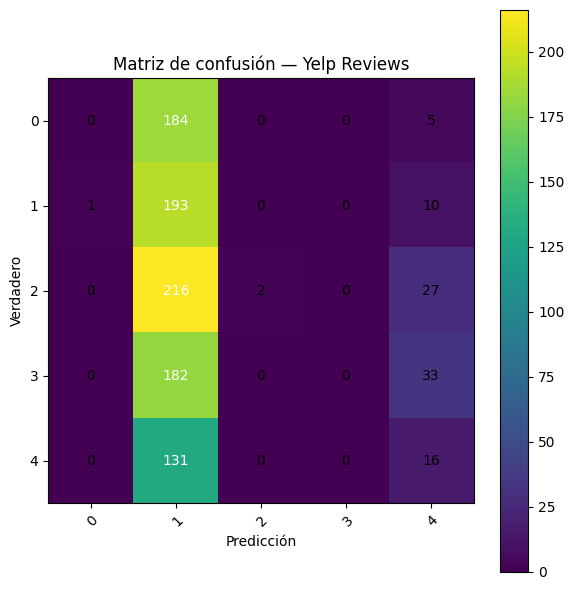

Asi que probe primero aumentar el numero de datos

Despues de duplicar los datos de entrenamiento, obtengo esta matriz:

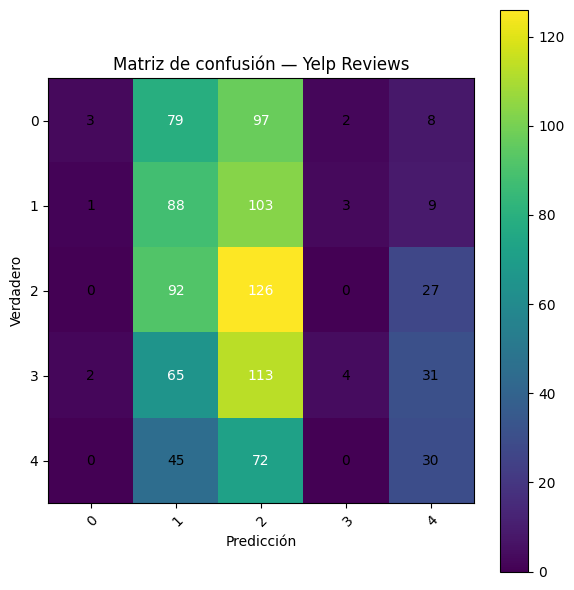

Voy a probar bajar el learning rate

Usando lr = 1e-5

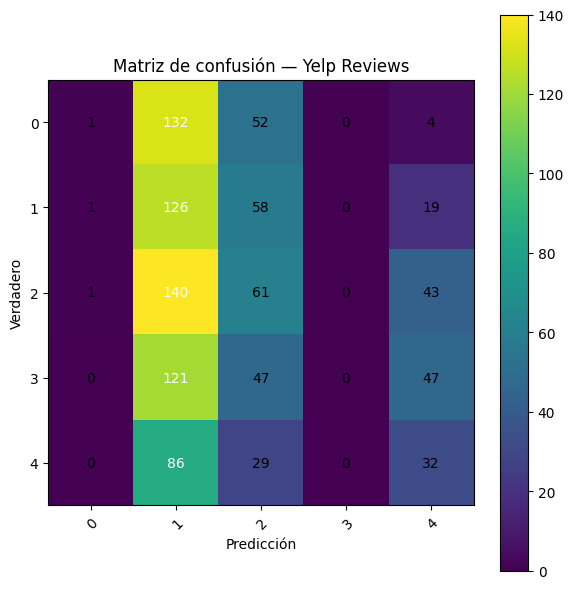

Lo bajo otra vez

Con lr = 2e-6

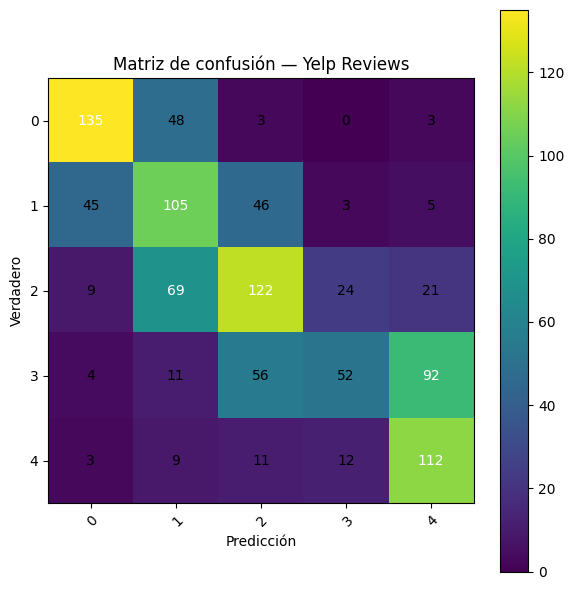

Mejoro muchisimo (quiza hubo suerte y justo dio con un minimo que daba informacion relevante).
Le agrego un warmup de un decimo de los pasos.

Llego a esto:

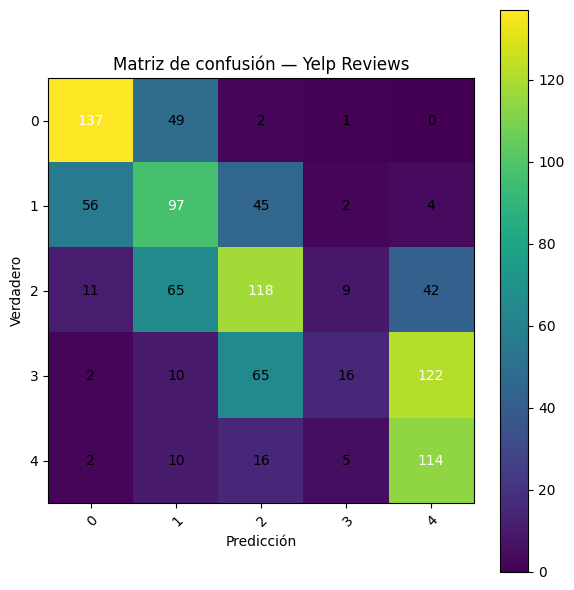

Voy a aumentar epocas de entrenamiento.

Sigue mejorando:

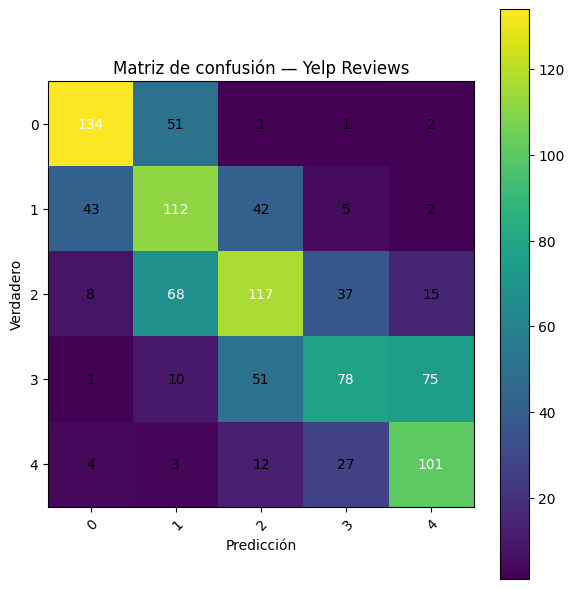

Ahora tambien puse la matriz con las metricas de clasificacion:

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       189
           1       0.46      0.55      0.50       204
           2       0.52      0.48      0.50       245
           3       0.53      0.36      0.43       215
           4       0.52      0.69      0.59       147

    accuracy                           0.54      1000
    macro avg      0.55      0.56      0.55      1000
    weighted avg   0.54      0.54      0.54      1000

Como ultima prueba, voy a probar entrenar descongelando ligeramente a BERT, solo la ultima capa.

Bajo las epocas de entrenamiento a 2, porque son muchos parametros a ajustar, y tambien el lr = 1e-6.